In [209]:
import pandas as pd 

ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
ETTm1 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm1.csv")
ETTh1 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm1.csv")
ETTh2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm1.csv")

In [277]:
def transform_date_column_and_drop_it(df, date_column_name:str, remain_same = True):
    df = df.copy()
    if remain_same: 
        df.drop(date_column_name, axis = 1, inplace=True)
    else: 
        df['day'] = df[date_column_name].dt.day
        df['month'] = df[date_column_name].dt.month
        df['hour'] = df[date_column_name].dt.hour
        df['minute'] = df[date_column_name].dt.minute
        df['weekday'] = df[date_column_name].dt.dayofweek
        df.drop(date_column_name, axis = 1, inplace=True)
    return df

def split_dataset(df, train_split_month=12, val_split_month=16, test_split_month=20): 
    data = df.copy()
    data['date'] = pd.to_datetime(data['date'])
    training_df = transform_date_column_and_drop_it(data[data['date'] < data['date'].min() + pd.DateOffset(months=train_split_month)],'date')
    val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
    test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')
    return training_df, val_df, test_df

In [278]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,future_steps, p_lag=0):
        self.df = df
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [279]:
import math
import torch.nn as nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size, n_features):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 
        self.n_features = n_features

    def forward(self, x):
        num_of_pads = (self.kernel_size - 1) // 2
        if self.kernel_size > self.n_features: 
            front = x[:, 0:1, :].repeat(1, num_of_pads + 1, 1)
        else: 
            front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7, batch_size = 8):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/1.5))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/1.5), future_steps)
        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/1.5))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/1.5), future_steps)
        self.decomp_layer = DecompositionLayer(decomp_kernel_size, n_features)
        self.criterion = nn.MSELoss()
        self.p_lag = p_lag
        self.batch_size = batch_size
        self.n_features = n_features
        self.future_steps = future_steps

    def forward(self, input):
        input = input.float()
        input_season, input_trend = self.decomp_layer(input)
        x_season = self.input_seasonal_layer(input_season.reshape(self.batch_size, self.p_lag*self.n_features))
        y_hat_season = self.output_seasonal_layer(x_season)
        x_trend = self.input_trend_layer(input_trend.reshape(self.batch_size, self.p_lag*self.n_features))
        y_hat_trend = self.output_trend_layer(x_trend)
        return y_hat_season + y_hat_trend

In [280]:
import numpy as np

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / (true + 1e-12)))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    mape = MAPE(pred, true)

    return mae, mse, mape

In [298]:
def train(epochs, p_lag, future_steps, n_features, training_df, validation_df, target_column = ['OT'], learning_rate=1.e-4, decomp_kernel_size= 7, batch_size = 8): 
    net = ARNet(p_lag=p_lag, n_features=n_features, future_steps=future_steps, decomp_kernel_size=decomp_kernel_size, batch_size=batch_size)

    train_data = DataLoader(TimeSeriesDataset(training_df, future_steps= future_steps, target_column = target_column,p_lag=p_lag), batch_size=batch_size, drop_last=True)
    train_loss_list = []
    val_data = DataLoader(TimeSeriesDataset(validation_df,future_steps= future_steps, target_column = target_column,p_lag=p_lag), batch_size=batch_size, drop_last=True)
    val_loss_list = []

    torch.set_grad_enabled(True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(epochs): 

        train_counter = 0
        val_counter = 0

        running_train_loss = 0.
        running_val_loss = 0.
        running_train_mae  = 0.
        running_train_mse  = 0.
        running_train_mape = 0.
        
        running_val_mae  = 0.
        running_val_mse  = 0.
        running_val_mape = 0.

        if epoch != 0 and (epoch) % 2 == 0: 
            learning_rate = learning_rate / 2
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        print(f"Current learning rate is : {learning_rate}")  
        print("---------------------------")
        for i, data in enumerate(train_data):
            inputs, labels = data
            labels = labels.squeeze(0).float()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = net.criterion(outputs, labels.squeeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()

            outputs_array = outputs.detach().cpu().numpy()
            labels_array = labels.squeeze(2).detach().cpu().numpy()
            mae, mse, mape= metric(pred=outputs_array, true=labels_array)
            running_train_mae  += mae
            running_train_mse  += mse
            running_train_mape += mape
            running_train_loss += loss.item()
            train_counter += batch_size
            if train_counter % 5000 == 0: 
                print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")
        train_loss_list.append(running_train_loss/train_counter)
            
        for i, data in enumerate(val_data):
            inputs, test_labels = data
            test_labels = test_labels.squeeze(0).float()
            output = net(inputs)
            val_loss = net.criterion(output, test_labels.squeeze(1))
            running_val_loss += val_loss.item()

            output_array = output.detach().cpu().numpy()
            test_labels_array = test_labels.squeeze(2).detach().cpu().numpy()
            mae, mse, mape = metric(pred=output_array, true=test_labels_array)
            running_val_mae  += mae
            running_val_mse  += mse
            running_val_mape += mape
            val_counter += batch_size
        val_loss_list.append(running_val_loss/val_counter)

        if epoch % 1 == 0:
            print("") 
            print(f"Epoch {epoch}: ")
            print("")
            print("Train metrics: -------")
            print(f"Running (training) loss is {running_train_loss/train_counter}.")
            print(f"Training MAE is {running_train_mae/train_counter}.")
            print(f"Training MSE is {running_train_mse/train_counter}.")
            print(f"Training MAPE is {running_train_mape/train_counter}.")
            print("")
            print("Val metrics: -------")
            print(f"Running (validation) loss is {running_val_loss/val_counter}.")
            print(f"Validation MAE is {running_val_mae/train_counter}.")
            print(f"Validation MSE is {running_val_mse/train_counter}.")
            print(f"Validation MAPE is {running_val_mape/train_counter}.")
            print("---------------------------")
    
    return net

In [282]:
import matplotlib.pyplot as plt

def plot_multistep_forecast(test_data, neural_net, future_steps, number_of_forecasts= 100): 
    output_list = []
    target_list = []
    for i, data in enumerate(test_data):
        inputs, labels = data
        output = neural_net(inputs)
        if i > number_of_forecasts: 
            break
        [output_list.append(out) for out in output.tolist()]
        [target_list.append(tar) for tar in labels.squeeze(1,2).tolist()]

    target = []
    for i in range(len(target_list)): 
        if i == 0: 
            target = target_list[i]
        else: 
            target.append(target_list[i][len(target_list[i])-1])

    fig = plt.figure(figsize=(15, 15))
    plt.plot(range(0, len(target)), target, 'g', label='target time series')
    for i, output in enumerate(output_list, start=0): 
        if i == 0:
            plt.plot(range(i, i +future_steps), output, color='#F39C12',linewidth=1, linestyle='-.',alpha=0.1, label='pred time series' + "\n" + f'{future_steps} each')
        else: 
            plt.plot(range(i, i +future_steps), output, color='#F39C12',linewidth=1, linestyle='-.',alpha=0.2)
    plt.legend(loc="upper left")
    plt.xlabel("Time Steps")
    plt.ylabel("Oil Temparature (Target variable)")

def evaluate_on_test_data(test_data, neural_net): 
    running_test_mae  = 0.
    running_test_mse  = 0.
    running_test_mape = 0.
    test_counter = 0

    for i, data in enumerate(test_data):
        inputs, test_labels = data
        test_labels = test_labels.squeeze(0).float()
        output = neural_net(inputs)
        output_array = output.detach().cpu().numpy()
        test_labels_array = test_labels.squeeze(2).detach().cpu().numpy()
        mae, mse, mape= metric(pred=output_array, true=test_labels_array)
        running_test_mae  += mae
        running_test_mse  += mse
        running_test_mape += mape
        test_counter += neural_net.batch_size

    print("Test metrics: -------")
    print(f"Validation MAE is {running_test_mae/test_counter}.")
    print(f"Validation MSE is {running_test_mse/test_counter}.")
    print(f"Validation MAPE is {running_test_mape/test_counter}.")
    print("---------------------------")

#### Experiments

In [299]:
#global parameters 
p_lag = 96*2
future_steps = 24
batch_size = 8
epochs = 12
learning_rate=1.e-4
decomp_kernel_size = 24

/tmp/ipykernel_2117/1238007648.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
/tmp/ipykernel_2117/1238007648.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')


Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 5.86252602186203
Current (running) training loss at iteration 10000 : 5.307165869903565
Current (running) training loss at iteration 15000 : 4.49267009139061
Current (running) training loss at iteration 20000 : 4.075059747445583
Current (running) training loss at iteration 25000 : 3.7715472311830522
Current (running) training loss at iteration 30000 : 4.061668407813708
Epoch 0: 

Train metrics: -------
Running (training) loss is 4.009259406183674.
Training MAE is 0.529864441684723.
Training MSE is 4.0560461256166125.
Training MAPE is 67067969.89059264.

Val metrics: -------
Running (validation) loss is 7.815750286271229.
Validation MAE is 0.26209477585621216.
Validation MSE is 2.6156725571836352.
Validation MAPE is 0.00851521101723967.
---------------------------
Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 

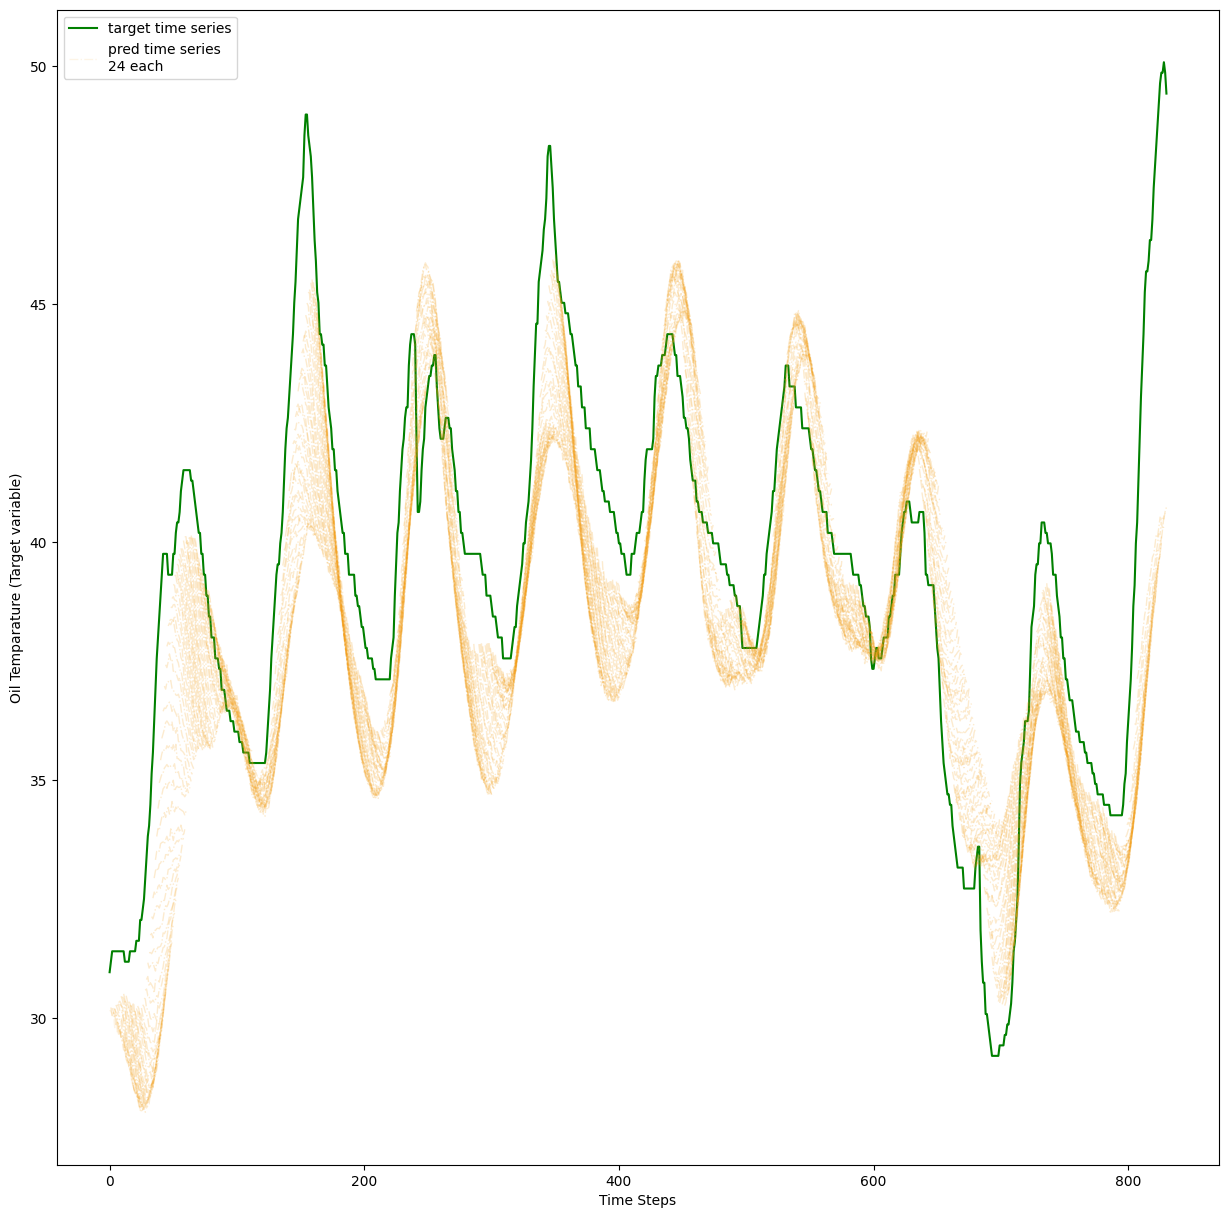

In [300]:
#ETTm2 

#different datasets
training_df, val_df, test_df = split_dataset(ETTm2)

#training
net = train(
            epochs = epochs, 
            n_features=len(training_df.columns), 
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            target_column = ['OT'], 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size
            )

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps)
evaluate_on_test_data(test_data = test_data, neural_net = net)

In [285]:
#ETTm1 

#different datasets
training_df, val_df, test_df = split_dataset(ETTm1)

#training
net = train(
            epochs = epochs, 
            n_features=len(training_df.columns), 
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            target_column = ['OT'], 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size
            )

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps)
evaluate_on_test_data(test_data = test_data, neural_net = net)

/tmp/ipykernel_2117/1238007648.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
/tmp/ipykernel_2117/1238007648.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')


Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 2.2900384942770002
Current (running) training loss at iteration 10000 : 2.027066507971287
Current (running) training loss at iteration 15000 : 1.9836415739655495
Current (running) training loss at iteration 20000 : 1.8210026030957698
Current (running) training loss at iteration 25000 : 1.7812355841684342
Current (running) training loss at iteration 30000 : 1.7582662939747176
Epoch 0: 

Train metrics: -------
Running (training) loss is 1.642371219195393.
Training MAE is 0.3383084567263295.
Training MSE is 1.648314535084238.
Training MAPE is 943321309.2714765.

Val metrics: -------
Running (validation) loss is 5.6343918158286845.
Validation MAE is 0.23154925788110245.
Validation MSE is 1.8759425845319804.
Validation MAPE is 0.018985833016123863.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 5000 : 1.049459461081028
Current (running) training loss at 

KeyboardInterrupt: 

/tmp/ipykernel_2117/1238007648.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
/tmp/ipykernel_2117/1238007648.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')


Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 2.70351689183712
Current (running) training loss at iteration 10000 : 1.9813702193170786
Current (running) training loss at iteration 15000 : 1.8080915245691935
Current (running) training loss at iteration 20000 : 1.5931475772254169
Current (running) training loss at iteration 25000 : 1.5142701379036902
Current (running) training loss at iteration 30000 : 1.4129675248116256
Epoch 0: 

Train metrics: -------
Running (training) loss is 1.3024029669542834.
Training MAE is 0.2936153183013781.
Training MSE is 1.3077670618695423.
Training RMSE is 0.3293767795444627.
Training MAPE is 378310452.3834003.
Training MSPE is 1.573888468759183e+21.
Training RSE is 3951905473.805336.
Training CORR is [-2.5985771e-06 -1.4513332e-06 -1.1134158e-06 -3.7440034e-07
  4.3871265e-07  9.7836710e-07  1.3837160e-06  1.9243819e-06].

Val metrics: -------
Running (validation) loss is 4.15842070912763

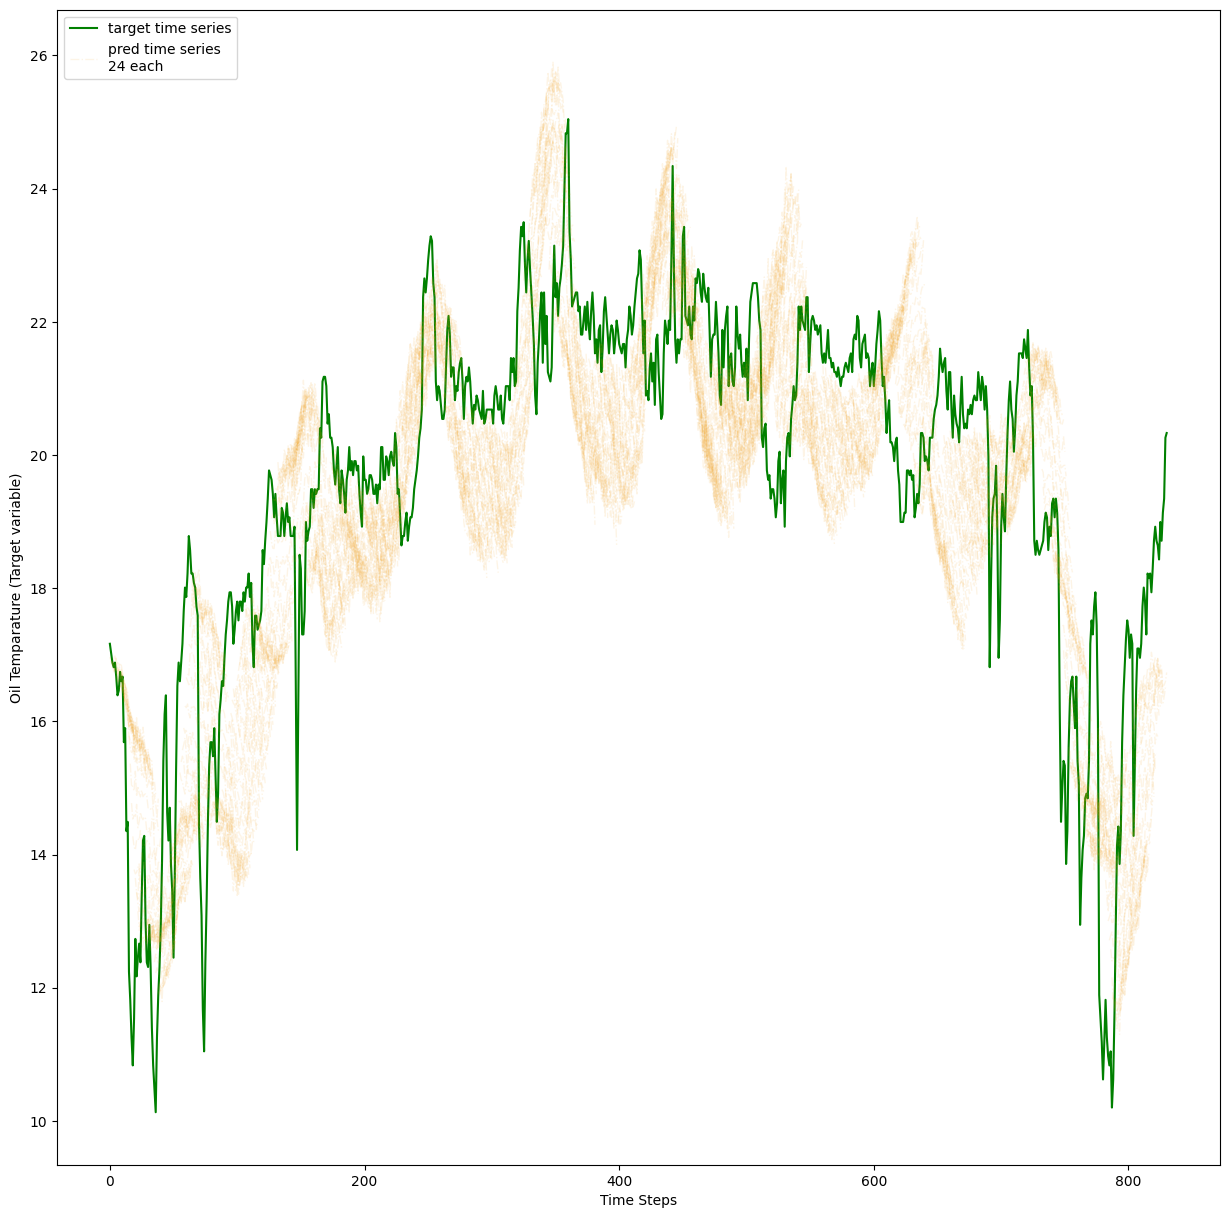

In [ ]:
#ETTh1 

#different datasets
training_df, val_df, test_df = split_dataset(ETTh1)

#training
net = train(
            epochs = epochs, 
            n_features=len(training_df.columns), 
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            target_column = ['OT'], 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size
            )

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps)
evaluate_on_test_data(test_data = test_data, neural_net = net)

/tmp/ipykernel_2117/1238007648.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
/tmp/ipykernel_2117/1238007648.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')


Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 2.5049675294160845
Current (running) training loss at iteration 10000 : 1.8899359775081277
Current (running) training loss at iteration 15000 : 1.754740403136611
Current (running) training loss at iteration 20000 : 1.5515935640998184
Current (running) training loss at iteration 25000 : 1.476702705897689
Current (running) training loss at iteration 30000 : 1.3784862323428193
Epoch 0: 

Train metrics: -------
Running (training) loss is 1.272593894019245.
Training MAE is 0.29192240888600635.
Training MSE is 1.2779694117644091.
Training RMSE is 0.32748535870481604.
Training MAPE is 384590355.5695945.
Training MSPE is 1.6053546980620603e+21.
Training RSE is 4081095492.5457187.
Training CORR is [-3.1386819e-06 -2.4635467e-06 -6.4139016e-07 -9.7831696e-07
  5.7350275e-07  2.3287118e-06  1.9237414e-06  3.2736082e-06].

Val metrics: -------
Running (validation) loss is 4.04465937651

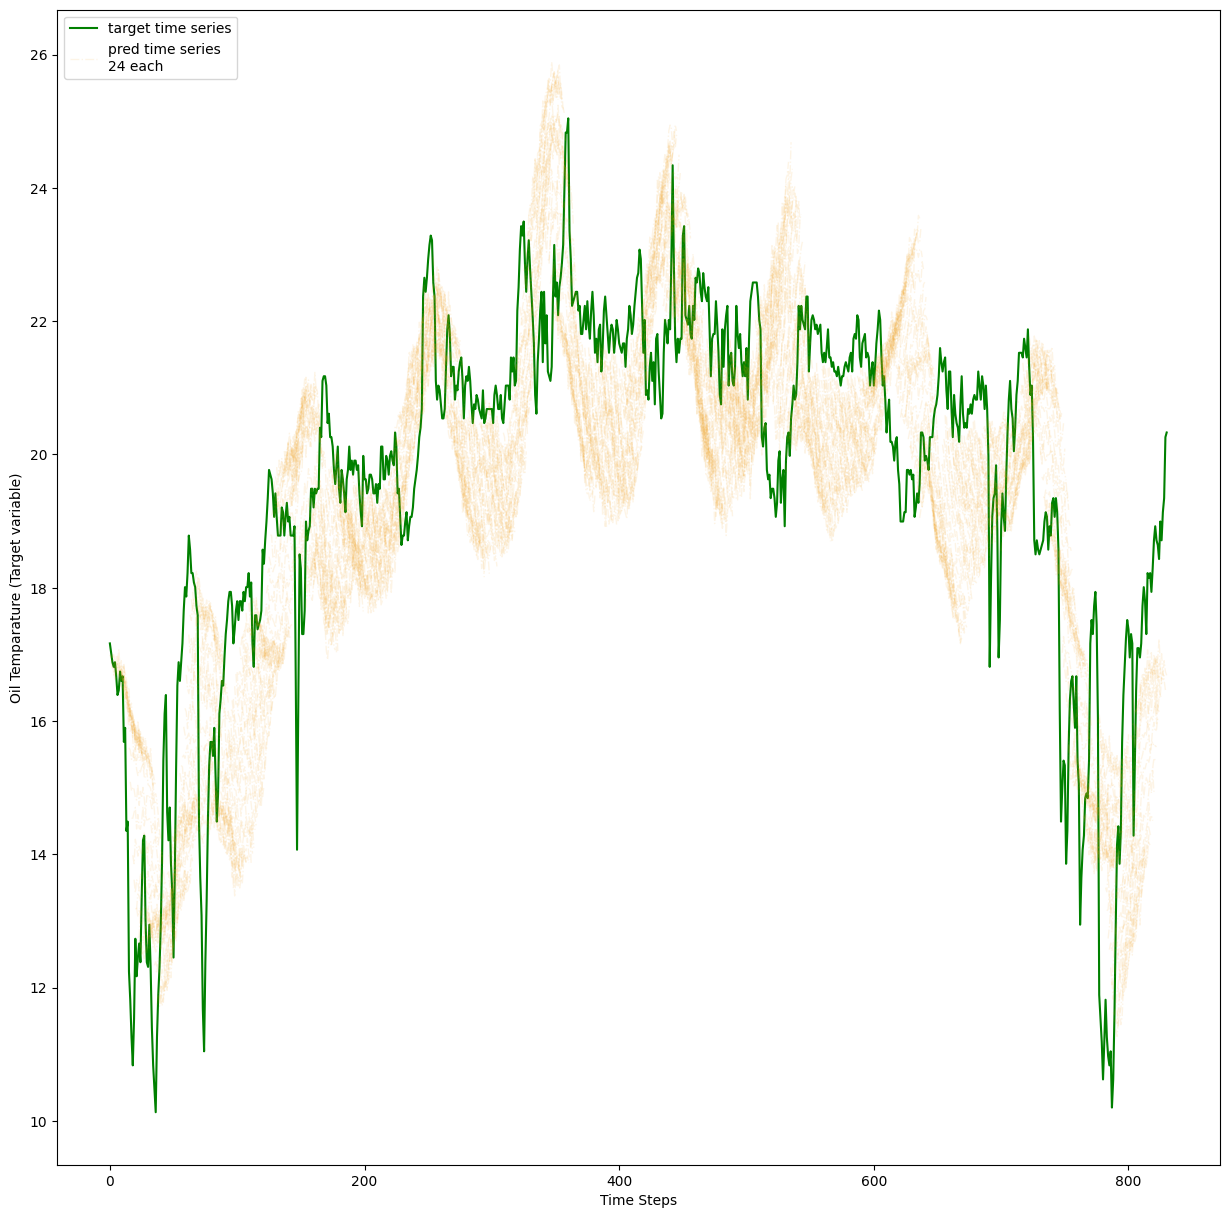

In [ ]:
#ETTh2

#different datasets
training_df, val_df, test_df = split_dataset(ETTh2)

#training
net = train(
            epochs = epochs, 
            n_features=len(training_df.columns), 
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            target_column = ['OT'], 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size
            )

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps)
evaluate_on_test_data(test_data = test_data, neural_net = net)